In [ ]:
!apt-get install openjdk-8-jdk-headless
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install plotly
!pip install -U kaleido

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Catch_Pink_Flamingo_game_analysis")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

In [ ]:
#IMPORTING LIBRARIES THAT WILL BE USED IN EXECUTION OF THIS PROJECT
import pyspark.sql
import datetime
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
import pyspark
import numpy as np
import pandas as pd
import pyspark.ml.feature
import pyspark.ml.classification 
import pyspark.ml.evaluation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import NaiveBayes 
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
import os
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
import webbrowser
import plotly.express as px
from pyspark.sql.functions import dayofweek
import pandas as pd

In [ ]:
!ls

Data  sample_data  spark-3.2.1-bin-hadoop2.7  spark-3.2.1-bin-hadoop2.7.tgz


In [ ]:
#Load all datasets into spark
game_users = spark.read.csv("Data/users.csv", header=True, inferSchema=True)
game_userSession = spark.read.csv("Data/user-session.csv", header=True, inferSchema=True)
game_team = spark.read.csv("Data/team.csv", header=True, inferSchema=True)
game_teamAssignment = spark.read.csv("Data/team-assignments.csv", header=True, inferSchema=True)
game_levelEvents = spark.read.csv("Data/level-events.csv", header=True, inferSchema=True)
game_gameClicks = spark.read.csv("Data/game-clicks.csv", header=True, inferSchema=True)
game_buyClicks = spark.read.csv("Data/buy-clicks.csv", header=True, inferSchema=True)
game_adClicks = spark.read.csv("Data/ad-clicks.csv", header=True, inferSchema=True)
combined_data = spark.read.csv("Data/combined-data.csv", header=True, inferSchema=True)

In [ ]:
#calling the datasets
game_users.show(4) 

+-------------------+------+--------+--------+----------+-------+
|          timestamp|userId|    nick| twitter|       dob|country|
+-------------------+------+--------+--------+----------+-------+
|2012-06-19 14:53:41|   442|pcjIOBKW|@SZhyOHv|1994-07-20|     BA|
|2012-06-19 19:29:01|   949| vAOfUkf|  @nkkNo|1971-04-22|     HU|
|2012-06-20 19:34:59|  1654|  qOOXSQ|  @SwOlw|1970-04-19|     IS|
|2012-06-21 01:18:29|  1586| px4gW51|@IrCHTnE|1965-11-23|     AM|
+-------------------+------+--------+--------+----------+-------+
only showing top 4 rows



In [ ]:
game_userSession.show(4)

+-------------------+-------------+------+------+------------+-----------+---------+------------+
|          timestamp|userSessionId|userId|teamId|assignmentId|sessionType|teamLevel|platformType|
+-------------------+-------------+------+------+------------+-----------+---------+------------+
|2016-05-26 14:47:30|         5675|   170|    90|        5423|      start|        1|      iphone|
|2016-05-27 00:06:54|         5675|   170|    90|        5423|        end|        1|      iphone|
|2016-05-26 14:43:09|         5795|   835|    39|        5300|      start|        1|     android|
|2016-05-27 08:06:54|         5795|   835|    39|        5300|        end|        1|     android|
+-------------------+-------------+------+------+------------+-----------+---------+------------+
only showing top 4 rows



In [ ]:
game_team.show(4)

+------+----------+-------------------+-------------------+--------------+------------+
|teamId|      name|   teamCreationTime|        teamEndTime|      strength|currentLevel|
+------+----------+-------------------+-------------------+--------------+------------+
|    79|   O1uJX7C|2016-06-12 15:33:27|9999-12-31 23:59:59|0.774473575316|           1|
|    92|  WeLHp8HZ|2016-06-12 21:54:20|9999-12-31 23:59:59| 0.17192602642|           1|
|     6|    mARlfz|2016-06-12 23:02:16|9999-12-31 23:59:59|0.537353043526|           1|
|     7|xO41jlAo0Y|2016-06-13 06:03:03|9999-12-31 23:59:59|0.394370370549|           1|
+------+----------+-------------------+-------------------+--------------+------------+
only showing top 4 rows



In [ ]:
game_teamAssignment.show(4)

+-------------------+----+------+------------+
|          timestamp|team|userId|assignmentId|
+-------------------+----+------+------------+
|2016-05-26 14:06:54|  64|   504|        5439|
|2016-05-26 14:07:00|  39|  1698|        5301|
|2016-05-26 14:07:04|  85|    81|        5540|
|2016-05-26 14:07:08|  95|  1976|        5307|
+-------------------+----+------+------------+
only showing top 4 rows



In [ ]:
game_levelEvents.show(4)

+-------------------+-------+------+---------+---------+
|          timestamp|eventId|teamId|teamLevel|eventType|
+-------------------+-------+------+---------+---------+
|2016-05-27 23:06:54|      0|     2|        1|      end|
|2016-05-27 23:06:54|      1|     2|        2|    start|
|2016-05-27 23:06:54|      2|     8|        1|      end|
|2016-05-27 23:06:54|      3|     8|        2|    start|
+-------------------+-------+------+---------+---------+
only showing top 4 rows



In [ ]:
game_gameClicks.show(4)

+-------------------+-------+------+-------------+-----+------+---------+
|          timestamp|clickId|userId|userSessionId|isHit|teamId|teamLevel|
+-------------------+-------+------+-------------+-----+------+---------+
|2016-05-26 15:06:55|    105|  1038|         5916|    0|    25|        1|
|2016-05-26 15:07:09|    154|  1099|         5898|    0|    44|        1|
|2016-05-26 15:07:14|    229|   899|         5757|    0|    71|        1|
|2016-05-26 15:07:14|    322|  2197|         5854|    0|    99|        1|
+-------------------+-------+------+-------------+-----+------+---------+
only showing top 4 rows



In [ ]:
game_buyClicks.show(4)

+-------------------+----+-------------+----+------+-----+-----+
|          timestamp|txId|userSessionId|team|userId|buyId|price|
+-------------------+----+-------------+----+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|  35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|  97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|  18|   121|    2|  3.0|
+-------------------+----+-------------+----+------+-----+-----+
only showing top 4 rows



In [ ]:
game_adClicks.show(4)

+-------------------+----+-------------+------+------+----+-----------+
|          timestamp|txId|userSessionId|teamId|userId|adId| adCategory|
+-------------------+----+-------------+------+------+----+-----------+
|2016-05-26 15:13:22|5974|         5809|    27|   611|   2|electronics|
|2016-05-26 15:17:24|5976|         5705|    18|  1874|  21|     movies|
|2016-05-26 15:22:52|5978|         5791|    53|  2139|  25|  computers|
|2016-05-26 15:22:57|5973|         5756|    63|   212|  10|    fashion|
+-------------------+----+-------------+------+------+----+-----------+
only showing top 4 rows



In [ ]:
combined_data.show(4)

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|
|  1658|         5649|        1|      iphone|              31|         5|       NULL|     NULL|
|  1589|         5650|        1|      iphone|              26|         2|       NULL|     NULL|
|  1863|         5651|        1|     android|              35|         4|       NULL|     NULL|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
only showing top 4 rows




EDA


In [ ]:
# plot line using plotly graph
def plot_line(df, x, xlabel, img_name):
    
    fig = px.line(df, x=x, y='count')
    fig.show()
    fig.write_image(f"images/{img_name}.png", scale=6, width=600, height=400)

In [ ]:
## Drop duplicate for user session to
user_session_unique = game_userSession.drop_duplicates(['userId'])

In [ ]:
user_session_unique.createOrReplaceTempView("TEMP")
game_userSession.createOrReplaceTempView("TEMP_2")
sql_1 = "SELECT platformType, COUNT(*) as count FROM TEMP GROUP BY platformType"
sql_2 = "SELECT userId, Count(*) as count FROM TEMP_2 GROUP BY userId ORDER BY count DESC"
platform_group_by = spark.sql(sql_1)
user_session_group = spark.sql(sql_2)

In [ ]:
userSession = game_userSession.toPandas()
platform_group_by = platform_group_by.toPandas()
user_session_group = user_session_group.toPandas()

userSession['timestamp'] = pd.to_datetime(userSession['timestamp'])
userSession['hour'] = userSession['timestamp'].dt.hour
userSession['day'] = userSession['timestamp'].dt.day
userSession['month'] = userSession['timestamp'].dt.month


df_hour_group = userSession.groupby(['hour']).size().reset_index(name='count')
df_day_group = userSession.groupby(['day']).size().reset_index(name='count')
df_month_group = userSession.groupby(['month']).size().reset_index(name='count')

In [ ]:
platform_group_by

,platformType,count
0,iphone,443
1,android,391
2,linux,55
3,mac,52
4,windows,152


In [ ]:
df_day_group.head(3)

,day,count
0,1,87
1,2,94
2,3,1075


In [ ]:
df_day_group['day'] = df_day_group['day'].astype('str')

In [ ]:
day_line = px.line( df_day_group, x = 'day', y = 'count', title = 'days of the week',  template="plotly_dark")
day_line.show()

In [ ]:
df_hour_group.head(2)

,hour,count
0,0,115
1,1,74


In [ ]:
df_hour_group['hour'] = df_hour_group['hour'].astype('str')

In [ ]:
hour_line = px.line( df_hour_group, x = 'hour', y = 'count', title = 'Hour of the day',  template="plotly_dark")
hour_line.show()

In [ ]:
df_month_group

,month,count
0,5,2865
1,6,6385


In [ ]:
month_line = px.line( df_month_group, x = 'month', y = 'count', title = 'Months of the year the game is played',  template="plotly_dark")
month_line.show()

In [ ]:
# creating function for bar graph, this function will be used in all bar plot 
def plot_bar(game_data, x, y, title, img_name):
  fig = px.bar(            
   game_data, 
    x = x,
    y = y,
    color = x ,# changes the color as per the changes in the column,
    template="plotly_dark"
  )

  fig.update_layout(
      title = title,
      xaxis_title = x,
      yaxis_title = y,
      xaxis = dict(           # attribures for x axis 
          showline = True,
          showgrid = False,
          linecolor = 'black',
          tickfont = dict(
              family = 'Calibri'
          )
      ),
      yaxis = dict(           # attribures for y axis 
          showline = True,
          showgrid = False,
          linecolor = 'black',
          tickfont = dict(
              family = 'Times New Roman'
          )
      )
     
  )
  fig.show()
  fig.write_image(f"{img_name}.png")

In [ ]:
# Call the function with the updated 'count_values' list
plot_bar(platform_group_by, 'platformType', 'count', "Device Distribution for flamingo game", "Device Distribution for flamingo game")

In [ ]:
## this anallze buyers
game_buyClicks.createOrReplaceTempView("Buyclicks")
buy_id_group = spark.sql("SELECT buyId, COUNT(*) as count FROM Buyclicks GROUP BY buyId")
buy_id_group_price = spark.sql("SELECT buyId, sum(price) as Total_price FROM Buyclicks GROUP BY buyId")


game_buy_clicks = game_buyClicks.toPandas()
buy_id_group = buy_id_group.toPandas()
buy_id_group_price = buy_id_group_price.toPandas()

In [ ]:
game_buy_clicks.head()

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


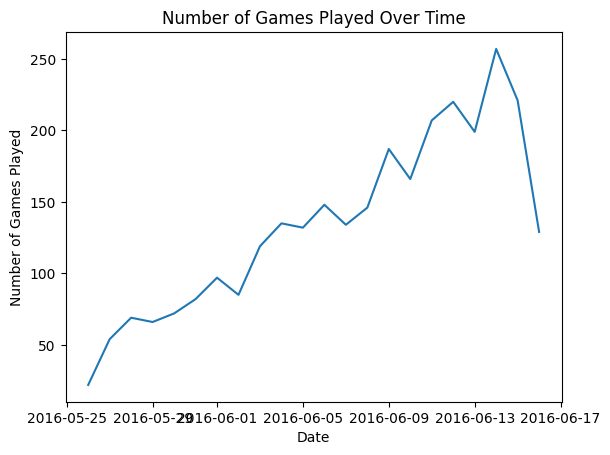

In [ ]:
# Convert timestamp column to datetime format
game_buy_clicks['timestamp'] = pd.to_datetime(game_buy_clicks['timestamp'])

# Group by date and count the number of games played
games_per_date = game_buy_clicks.groupby(game_buy_clicks['timestamp'].dt.date)['buyId'].count()

# Plot the line chart
plt.plot(games_per_date.index, games_per_date.values)
plt.xlabel('Date')
plt.ylabel('Number of Games Played')
plt.title('Number of Games Played Over Time')
plt.show()

In [ ]:
import plotly.graph_objects as go
# Group the data by team and calculate the purchase amount
team_purchase = game_buy_clicks.groupby('team')['price'].sum()

# Sort teams based on purchase amount in descending order
sorted_teams = team_purchase.sort_values(ascending=False)

# Get the team with the highest purchase
team_with_highest_purchase = sorted_teams.index[0]

# Filter the data for the team with the highest purchase
highest_purchase_data = game_buy_clicks[game_buy_clicks['team'] == team_with_highest_purchase]

# Create the box plot using Plotly
fig = go.Figure()
fig.add_trace(go.Box(y=highest_purchase_data['price'], name="team_with_highest_purchase"))
fig.update_layout(
    title="Team with the Highest Purchase",
    xaxis_title="Team",
    yaxis_title="Purchase Amount"
)
fig.show()

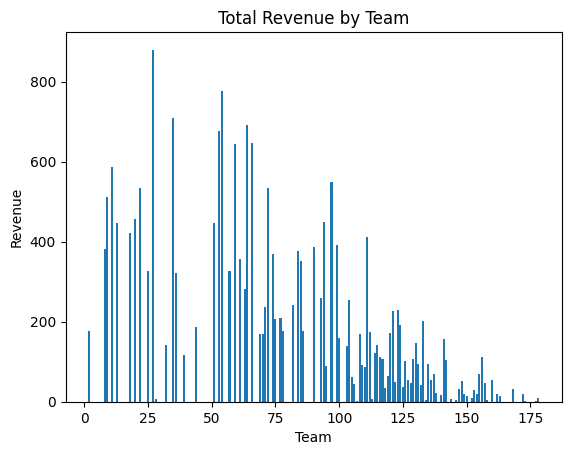

In [ ]:
# Group by team and calculate the total revenue per team
team_revenue = game_buy_clicks.groupby('team')['price'].sum()

# Plot the stacked bar chart
plt.bar(team_revenue.index, team_revenue.values, label='Team Revenue')
plt.xlabel('Team')
plt.ylabel('Revenue')
plt.title('Total Revenue by Team')

plt.show()

In [ ]:
buy_id_group.head()

,buyId,count
0,1,269
1,3,337
2,5,610
3,4,425
4,2,714


In [ ]:
buy_id_group_price.head()

,buyId,Total_price
0,1,538.0
1,3,1685.0
2,5,12200.0
3,4,4250.0
4,2,2142.0


In [ ]:
# Call the function with the updated 'count_values' list
plot_bar(buy_id_group, 'buyId', 'count', "Item Distribution for buy clicks", "Item Distribution for for buy clicks")

In [ ]:
# Call the function with the updated 'count_values' list
plot_bar(buy_id_group_price, 'buyId', 'Total_price', "total price Distribution  for items", "total price Distribution  for items")

In [ ]:
def plot_bar(data, x, y, title, x_label, y_label, img_name):
    plt.figure(figsize=(15, 10))
    sns.barplot(data=data, x=x, y=y)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.savefig(f"{img_name}.png")
    plt.show()


In [ ]:
# Extract day and hour for analysis with pandas
import pandas as pd
game_buy_clicks['timestamp'] = pd.to_datetime(game_buy_clicks['timestamp'])
game_buy_clicks['day'] = game_buy_clicks['timestamp'].dt.day_name()
game_buy_clicks['hour'] = game_buy_clicks['timestamp'].dt.hour

game_day_group = game_buy_clicks.groupby(['day']).size().reset_index(name='count')
game_hour_group = game_buy_clicks.groupby(['hour']).size().reset_index(name='count')

Analysis for other patterns
The code below contains analysis and plots for other noticable patterns

In [ ]:
game_gameClicks.createOrReplaceTempView("game_click")

In [ ]:
spark.sql("select * from temp").show(2)

+-------------------+-------------+------+------+------------+-----------+---------+------------+
|          timestamp|userSessionId|userId|teamId|assignmentId|sessionType|teamLevel|platformType|
+-------------------+-------------+------+------+------------+-----------+---------+------------+
|2016-06-07 21:36:54|        23473|     0|   157|       21399|      start|        1|      iphone|
|2016-05-26 14:59:59|         5835|     1|    99|        5213|      start|        1|     android|
+-------------------+-------------+------+------+------------+-----------+---------+------------+
only showing top 2 rows



In [ ]:
spark.sql("select * from game_click").show(3)

+-------------------+-------+------+-------------+-----+------+---------+
|          timestamp|clickId|userId|userSessionId|isHit|teamId|teamLevel|
+-------------------+-------+------+-------------+-----+------+---------+
|2016-05-26 15:06:55|    105|  1038|         5916|    0|    25|        1|
|2016-05-26 15:07:09|    154|  1099|         5898|    0|    44|        1|
|2016-05-26 15:07:14|    229|   899|         5757|    0|    71|        1|
+-------------------+-------+------+-------------+-----+------+---------+
only showing top 3 rows



In [ ]:
# Hit ratio compared to buy pattern of to putchasing users

user_hit_ratio = spark.sql("""select game.userId, ROUND(SUM(game.isHit) / COUNT(*) * 100, 2) as hitRatio
                                  FROM game_click game 
                                  WHERE game.userId IN (SELECT userId  
                                                    FROM Buyclicks GROUP BY userId ORDER BY SUM(price) DESC LIMIT 20)
                                  group By game.userId
                                  ORDER BY hitRatio DESC
                                  LIMIT 20

            """)

In [ ]:
user_hit_ratio.show(5)

+------+--------+
|userId|hitRatio|
+------+--------+
|  1732|    16.3|
|   178|   15.75|
|   471|    14.5|
|  1260|   14.11|
|  1697|   13.96|
+------+--------+
only showing top 5 rows



In [ ]:
team_hit_ratio = spark.sql("""
        select game.teamId, ROUND(SUM(isHit) / COUNT(*) * 100, 2) as hitRatio
        from game_click game
        WHERE game.teamId IN (SELECT team 
                        FROM Buyclicks 
                        GROUP BY team 
                        ORDER BY SUM(price) DESC 
                        LIMIT 20)
        group By game.teamId
        ORDER BY hitRatio DESC
        LIMIT 20
""")

In [ ]:
team_hit_ratio.show(5)

+------+--------+
|teamId|hitRatio|
+------+--------+
|   111|   12.15|
|    11|   11.86|
|    94|    11.7|
|    59|   11.61|
|    53|    11.6|
+------+--------+
only showing top 5 rows



In [ ]:
team_hit_ratio = team_hit_ratio.toPandas()
team_hit_ratio['teamId'] = team_hit_ratio['teamId'].astype("str") 

user_hit_ratio = user_hit_ratio.toPandas()
user_hit_ratio['userId'] = user_hit_ratio['userId'].astype("str")

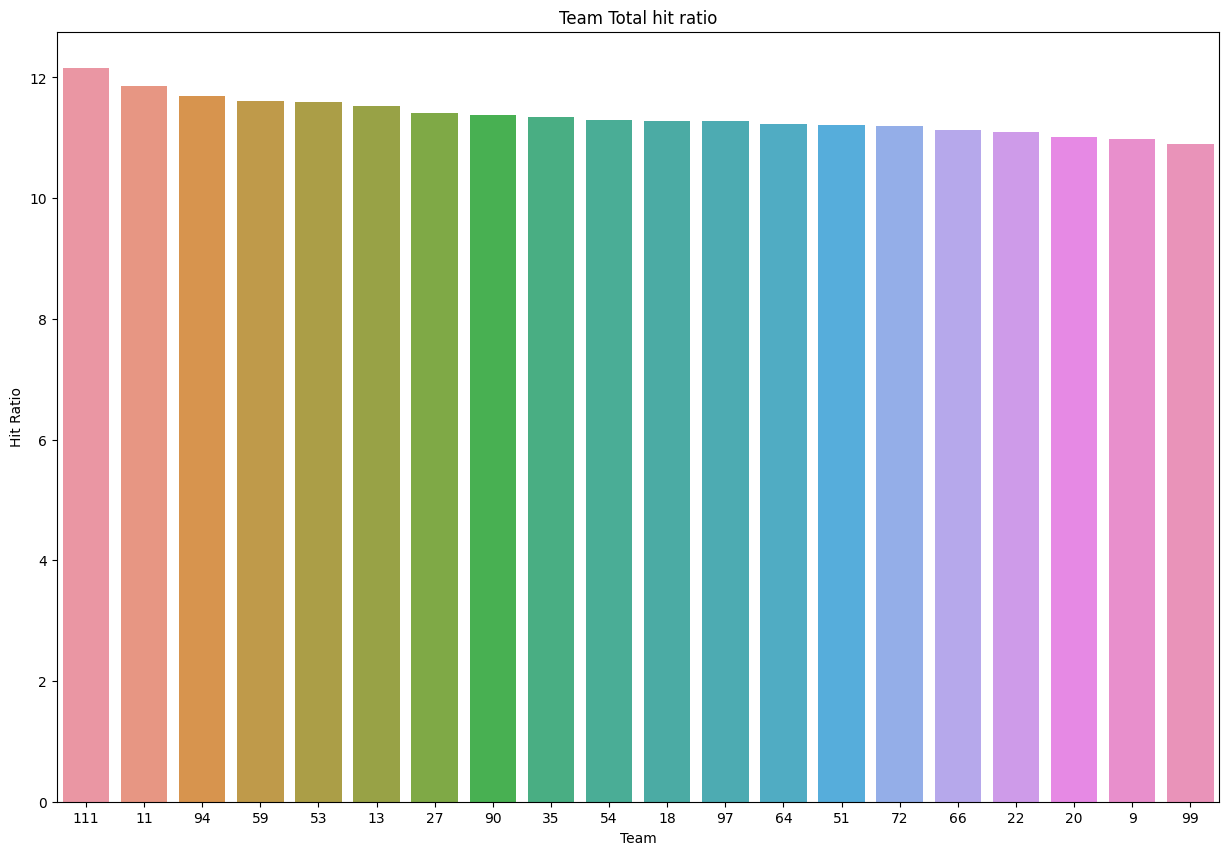

In [ ]:
# Call the function with the provided data and labels
plot_bar(team_hit_ratio, 'teamId', 'hitRatio', 'Team Total hit ratio', 'Team', 'Hit Ratio', 'team_hit_ratio')

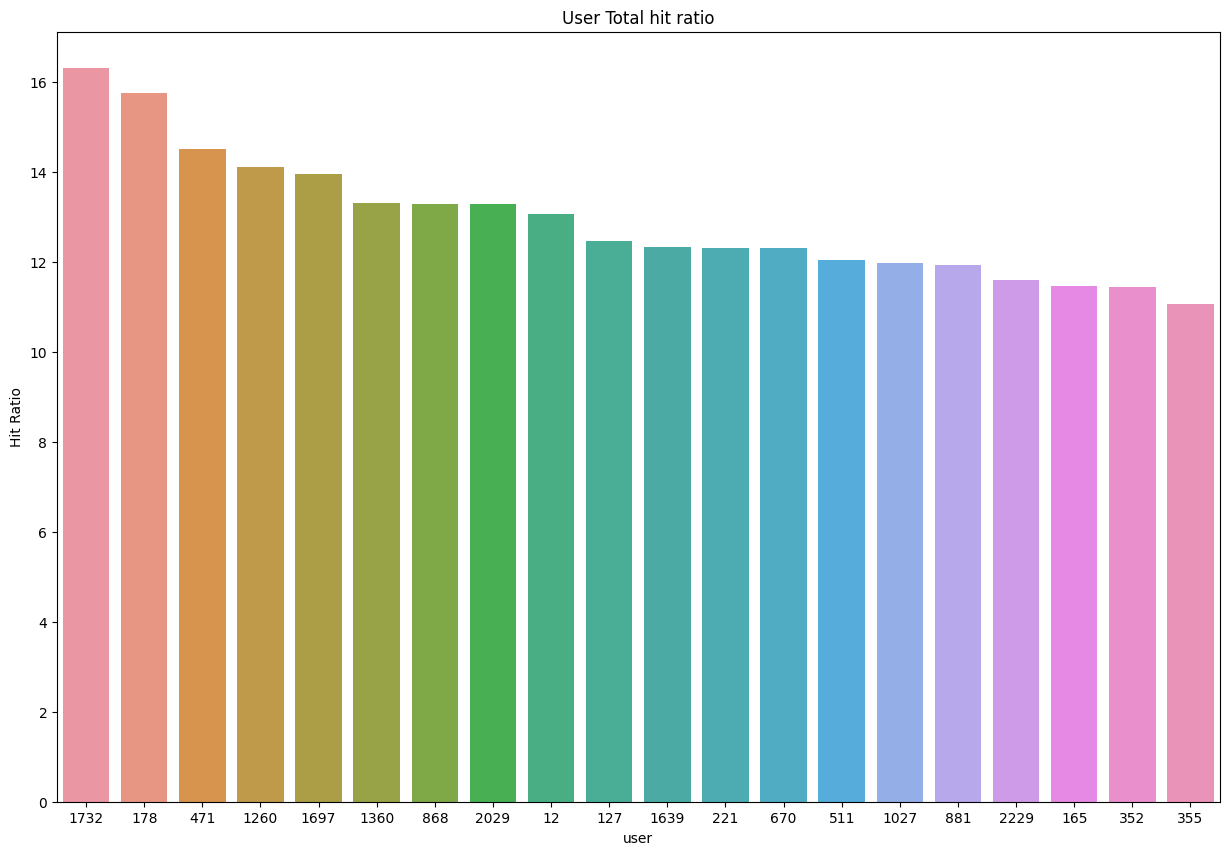

In [ ]:
# Call the function with the updated 'count_values' list
plot_bar(user_hit_ratio, 'userId', 'hitRatio', 'User Total hit ratio','user', 'Hit Ratio', 'user_hit_ratio')

In [ ]:
import plotly.graph_objects as go
def plot_pie(df, label, value, img_name):

  fig = go.Figure(data=[go.Pie(labels=df[label], values=df[value])])

  # Adjust the margin to remove whitespace
  fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
  fig.update_layout({
      'font': {'size': 18}
  })


  # Show the chart
  fig.show()

In [ ]:
game_users.createOrReplaceTempView("users")

In [ ]:
spark.sql("""
      SELECT DISTINCT(COUNT(userId)) FROM BuyClicks
""").show()

+-------------+
|count(userId)|
+-------------+
|         2947|
+-------------+



In [ ]:
spark.sql("""
    SELECT userId, 'Yes' as Buy FROM BuyClicks
""").show()

+------+---+
|userId|Buy|
+------+---+
|  1300|Yes|
|   868|Yes|
|   819|Yes|
|   121|Yes|
|  2222|Yes|
|  1304|Yes|
|  1027|Yes|
|  2199|Yes|
|  1544|Yes|
|  2199|Yes|
|  1623|Yes|
|  1027|Yes|
|  1065|Yes|
|    83|Yes|
|  1652|Yes|
|   518|Yes|
|  2221|Yes|
|  1815|Yes|
|  2146|Yes|
|  1457|Yes|
+------+---+
only showing top 20 rows



In [ ]:
users_bought = spark.sql("""
    SELECT DISTINCT(userId), 'Users who purchased' as Bought_items FROM users
    WHERE userId IN (SELECT DISTINCT(userId) FROM BuyClicks)

    UNION ALL

    SELECT DISTINCT(userId), 'User who didnt purchase' as Bought_items FROM users
    WHERE userId NOT IN (SELECT DISTINCT(userId) FROM BuyClicks)
""")
users_bought_group = users_bought.groupby('Bought_items').count()
users_bought_group = users_bought_group.toPandas()
users = game_users.toPandas()

In [ ]:
users_bought_group.head()

,Bought_items,count
0,Users who purchased,546
1,User who didnt purchase,1847


In [ ]:
plot_pie(users_bought_group, 'Bought_items' , 'count', 'users_that_bought')

In [ ]:
#analysing the age range of users in the catch the flamingo
users['dob'] = pd.to_datetime(users['dob'])
users['Year'] =  users['dob'].dt.year
users['Age'] = users['Year'].apply(lambda x: 2023 - x)

bins = [20, 30, 40, 50,60, 70, 100]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70','80+']
users['Age_range'] = pd.cut(users['Age'], bins=bins, labels=labels)

age_group = users.groupby(['Age_range']).size().reset_index(name='count')

In [ ]:
age_group

,Age_range,count
0,20-30,335
1,30-40,600
2,40-50,544
3,50-60,437
4,60-70,317
5,80+,160


In [ ]:
plot_pie(age_group, 'Age_range', 'count', 'Age_group')

In [ ]:
# the analysis and plot below analyses the adcategory to find which category that had more clicks.
ads_click = game_adClicks.toPandas()
game_adClicks.createOrReplaceTempView("ads")
ads_click_group = ads_click.groupby(['adCategory']).size().reset_index(name='count')

In [ ]:
# 
import plotly.express as px

fig = px.bar(ads_click_group, x="count", y="adCategory", orientation='h', text_auto=True)
fig.show()

In [ ]:
#Analysing Team Strenght
game_team.createOrReplaceTempView("teams")
team_strenght = spark.sql("""
    select * from teams
    order by strength DESC
    LIMIT 5
""")

team_strenght = team_strenght.toPandas()

In [ ]:
team_strenght

,teamId,name,teamCreationTime,teamEndTime,strength,currentLevel
0,161,vBm7Odv,2016-06-07 19:36:54,2016-06-08 06:06:54,0.994851,1
1,46,5ruGsz7L,2016-06-15 08:43:34,9999-12-31 23:59:59,0.957040,1
2,9,pDG2bAh8T,2016-06-13 17:39:55,9999-12-31 23:59:59,0.952176,1
3,101,t1tqUapfHxV,2016-06-14 15:25:50,9999-12-31 23:59:59,0.947642,1
4,12,WHKzmMokDcK,2016-06-15 22:44:03,9999-12-31 23:59:59,0.943434,1


In [ ]:
plot_pie(team_strenght, "teamId", "strength", "team_strenght")

In [ ]:
#raltionship between team strenght and the buy pattern
st_p = spark.sql("""
            WITH team_s as (
              select teamId, strength
              from teams
            ),

            buy as (
              select team, SUM(price) as total_price
              from BuyClicks
              group by team
            )

            select t.teamId, t.strength, b.total_price
            from team_s t
            join buy b
            on t.teamId = b.team
             """)
st_p = st_p.toPandas()

In [ ]:
st_p.head()

,teamId,strength,total_price
0,85,0.132215,352.0
1,53,0.237000,677.0
2,78,0.796923,176.0
3,28,0.668180,8.0
4,27,0.141377,880.0


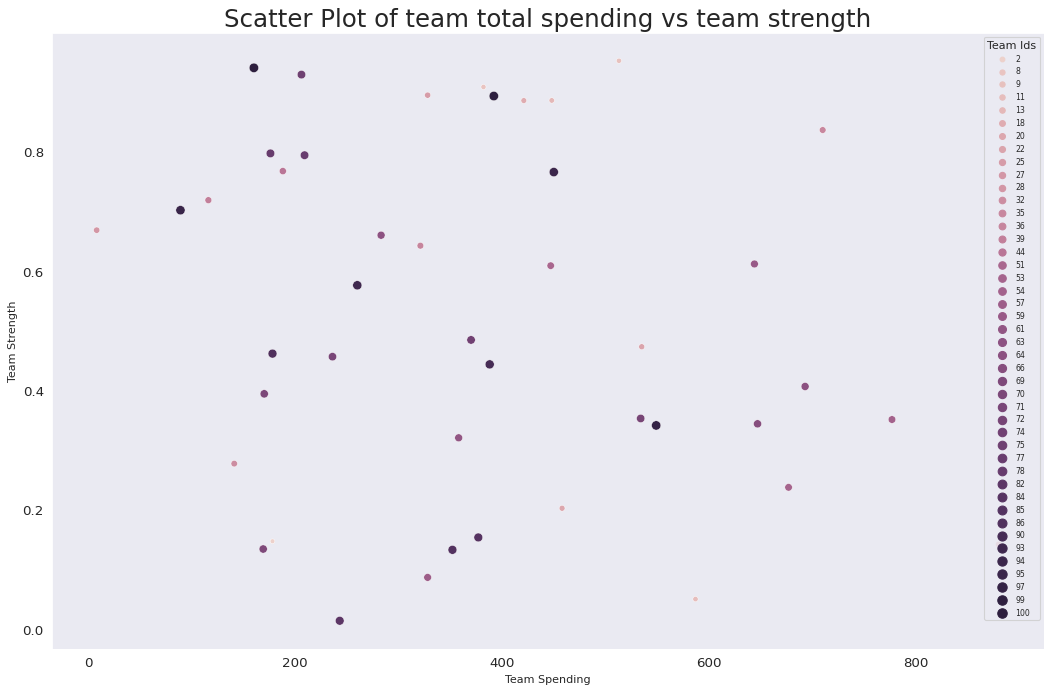

In [ ]:
from matplotlib import patches
from scipy.spatial import ConvexHull
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
sns.set_style("dark")


# As many colors as there are unique midwest['category']
categories = np.unique(st_p['teamId'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Step 2: Draw Scatterplot with unique color for each category
fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')    


# Step 3: Draw Scatterplot

ax = sns.scatterplot(data=st_p, x="total_price", y="strength", hue="teamId",size="teamId", legend="full")
m, b = np.polyfit(st_p["total_price"], st_p["strength"], 1)



plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.xlabel("Team Spending")
plt.ylabel("Team Strength")
plt.legend(title='Team Ids', fontsize=7)

plt.title("Scatter Plot of team total spending vs team strength", fontsize=22)

plt.show()   

#.stat.corr("total_spending","total_strength")



import plotly.express as px 
def plot_scatter(img_name):
    # simple bar graph
    fig = px.scatter(           # replace line with bar in line chart code 
        st_p,
        x="total_price", 
        y="strength",
        template = "plotly")

    fig.update_layout(
        xaxis_title = '<b><span style="font-family: Arial, font-size: 10pt">Total Price</span></b>',
        yaxis_title = '<b><span style="font-family: Arial, font-size: 10pt">Strength</span></b>',
        xaxis = dict(           # attribures for x axis 
            showline = True,
            showgrid = True,
            linecolor = 'black',
            tickfont = dict(
                family = 'Times New Roman',
                size = 18
            )
        ),
        yaxis = dict(           # attribures for y axis 
            showline = True,
            showgrid = True,
            linecolor = 'black',
            tickfont = dict(
                family = 'Times New Roman',
                size = 18
            )
        ),
        plot_bgcolor = 'white' 
    )
    fig.show()
    fig.write_image(f"images/{img_name}.png", scale=6, width=800, height=600)

In [ ]:
import plotly.express as px 
def plot_scatter(img_name):
    # simple bar graph
    fig = px.scatter(           # replace line with bar in line chart code 
        st_p,
        x="total_price", 
        y="strength",
        template = "plotly")

    fig.update_layout(
        xaxis_title = '<b><span style="font-family: Arial, font-size: 10pt">Total Price</span></b>',
        yaxis_title = '<b><span style="font-family: Arial, font-size: 10pt">Strength</span></b>',
        xaxis = dict(           # attribures for x axis 
            showline = True,
            showgrid = True,
            linecolor = 'black',
            tickfont = dict(
                family = 'Times New Roman',
                size = 18
            )
        ),
        yaxis = dict(           # attribures for y axis 
            showline = True,
            showgrid = True,
            linecolor = 'black',
            tickfont = dict(
                family = 'Times New Roman',
                size = 18
            )
        ),
        plot_bgcolor = 'white' 
    )
    fig.show()

In [ ]:
plot_scatter("price_and_strentgh_scatter")

In [ ]:
def plot_scatter(img_name):
    # Create the scatter plot using Seaborn
    sns.scatterplot(data=st_p, x="total_price", y="strength")
    plt.figure(figsize=(15, 10))

    # Set the axis labels and title
    plt.xlabel('Total Price')
    plt.ylabel('Strength')
    plt.title('Scatter Plot of Total Price vs Strength')

    # Save and show the scatter plot
    plt.show()

In [ ]:
#Combine data for ML -> classification and clustering


In [ ]:
spark.sql("""
    select userId, (2023 - EXTRACT(year FROM dob)) as Year from users
""").show()

+------+----+
|userId|Year|
+------+----+
|   442|  29|
|   949|  52|
|  1654|  53|
|  1586|  58|
|   599|  29|
|   952|  37|
|  1056|  32|
|    91|  46|
|   809|  72|
|    75|  44|
|  2224|  27|
|   361|  43|
|   584|  66|
|   295|  46|
|  1493|  44|
|  1605|  42|
|   848|  34|
|   962|  74|
|  2034|  40|
|   379|  43|
+------+----+
only showing top 20 rows



In [ ]:
combined_data.createOrReplaceTempView('cb')

In [ ]:
combined_data.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|
|  1658|         5649|        1|      iphone|              31|         5|       NULL|     NULL|
|  1589|         5650|        1|      iphone|              26|         2|       NULL|     NULL|
|  1863|         5651|        1|     android|              35|         4|       NULL|     NULL|
|   937|         5652|        1|     android|              39|         0|          1|     1.00|
|   342|         5653|        1|     android|              36|         5|       NULL|     NULL|
|   849|         5654|        1|      iphone|              40|         5|       NULL|     NULL|
|  1277|         5655|        1|     win

In [ ]:
from pyspark.sql.functions import rand, monotonically_increasing_id

final_df = combined_data.orderBy(rand())

In [ ]:
final_df.count()

4619

In [ ]:
# Drop missing values
# final_df = final_df.na.drop()
# final_df = final_df.na.drop('any')
from pyspark.sql.functions import col

filtered_df = final_df.filter((col("count_buyId") != "NULL") & (col("avg_price") != "NULL"))

# Show the resulting DataFrame
print(filtered_df.count())
filtered_df.show()

1411
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   511|        20787|        6|      iphone|             123|        20|          1|    20.00|
|  1262|        29232|        3|     windows|             388|        53|          2|     1.00|
|  2306|        10050|        3|     android|             102|        15|          1|     3.00|
|  1321|        26651|        7|      iphone|              90|         5|          2|    20.00|
|  1555|        26430|        7|      iphone|              91|        10|          1|     3.00|
|   530|        28123|        5|     android|             361|        47|          3|     3.00|
|   343|        20910|        6|     windows|             117|        15|          1|     1.00|
|  1120|        20667|        6|   

In [ ]:
import pyspark.ml.feature
import pyspark.ml.classification 
import pyspark.ml.evaluation
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import NaiveBayes

In [ ]:
# label encode the categorical data "platform type"
indexer = StringIndexer(inputCol= "platformType", outputCol = "paltformType_1").fit(filtered_df)
df = indexer.transform(filtered_df)

In [ ]:
df.show(5)

+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|paltformType_1|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------+
|   511|        20787|        6|      iphone|             123|        20|          1|    20.00|           0.0|
|  1262|        29232|        3|     windows|             388|        53|          2|     1.00|           2.0|
|  2306|        10050|        3|     android|             102|        15|          1|     3.00|           1.0|
|  1321|        26651|        7|      iphone|              90|         5|          2|    20.00|           0.0|
|  1555|        26430|        7|      iphone|              91|        10|          1|     3.00|           0.0|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------+
o

In [ ]:
df.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|paltformType_1|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------+
|   511|        20787|        6|      iphone|             123|        20|          1|    20.00|           0.0|
|  1262|        29232|        3|     windows|             388|        53|          2|     1.00|           2.0|
|  2306|        10050|        3|     android|             102|        15|          1|     3.00|           1.0|
|  1321|        26651|        7|      iphone|              90|         5|          2|    20.00|           0.0|
|  1555|        26430|        7|      iphone|              91|        10|          1|     3.00|           0.0|
|   530|        28123|        5|     android|             361|        47|          3|     3.00|           1.0|
|

In [ ]:
df.createOrReplaceTempView('df')

#WHEN avg_price <= 10 THEN 1

df = spark.sql("""
  SELECT *, 
  CASE WHEN avg_price <= 5 THEN 0
       WHEN avg_price <= 10 THEN 1
       ELSE 2
  END AS purchase_class
  FROM df
""")

In [ ]:
df.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------+--------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|paltformType_1|purchase_class|
+------+-------------+---------+------------+----------------+----------+-----------+---------+--------------+--------------+
|   511|        20787|        6|      iphone|             123|        20|          1|    20.00|           0.0|             2|
|  1262|        29232|        3|     windows|             388|        53|          2|     1.00|           2.0|             0|
|  2306|        10050|        3|     android|             102|        15|          1|     3.00|           1.0|             0|
|  1321|        26651|        7|      iphone|              90|         5|          2|    20.00|           0.0|             2|
|  1555|        26430|        7|      iphone|              91|        10|          1|     3.00|           0.0|        

In [ ]:
df = df.drop('userId') 
df = df.drop('userSessionId')
#df = df.drop('avg_price')

In [ ]:
df.show()

+---------+------------+----------------+----------+-----------+---------+--------------+--------------+
|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|paltformType_1|purchase_class|
+---------+------------+----------------+----------+-----------+---------+--------------+--------------+
|        6|      iphone|             123|        20|          1|    20.00|           0.0|             2|
|        3|     windows|             388|        53|          2|     1.00|           2.0|             0|
|        3|     android|             102|        15|          1|     3.00|           1.0|             0|
|        7|      iphone|              90|         5|          2|    20.00|           0.0|             2|
|        7|      iphone|              91|        10|          1|     3.00|           0.0|             0|
|        5|     android|             361|        47|          3|     3.00|           1.0|             0|
|        6|     windows|             117|        15|   

In [ ]:
new_df = df.selectExpr("cast(count_buyId as int) count_buyId", 
                       "cast(teamLevel as int) teamLevel",
                       "cast(count_gameclicks as int) count_gameclicks",
                       "cast(count_hits as int) count_hits",
                       "cast(paltformType_1 as int) paltformType",
                       "cast(purchase_class as int) label",
                      "cast(avg_price as int)  avgprice")

In [ ]:
p_df = new_df.toPandas()
p_df

,count_buyId,teamLevel,count_gameclicks,count_hits,paltformType,label,avgprice
0,1,6,123,20,0,2,20
1,2,3,388,53,2,0,1
2,1,3,102,15,1,0,3
3,2,7,90,5,0,2,20
4,1,7,91,10,0,0,3
...,...,...,...,...,...,...,...
1406,1,5,90,10,1,0,3
1407,2,7,118,14,1,0,2
1408,1,6,50,3,2,0,2
1409,2,6,281,34,0,2,20


In [ ]:
mod_df = p_df
mod_df.drop(['paltformType', 'avgprice'], axis=1, inplace=True)

In [ ]:
mod_df

,count_buyId,teamLevel,count_gameclicks,count_hits,label
0,1,6,123,20,2
1,2,3,388,53,0
2,1,3,102,15,0
3,2,7,90,5,2
4,1,7,91,10,0
...,...,...,...,...,...
1406,1,5,90,10,0
1407,2,7,118,14,0
1408,1,6,50,3,0
1409,2,6,281,34,2


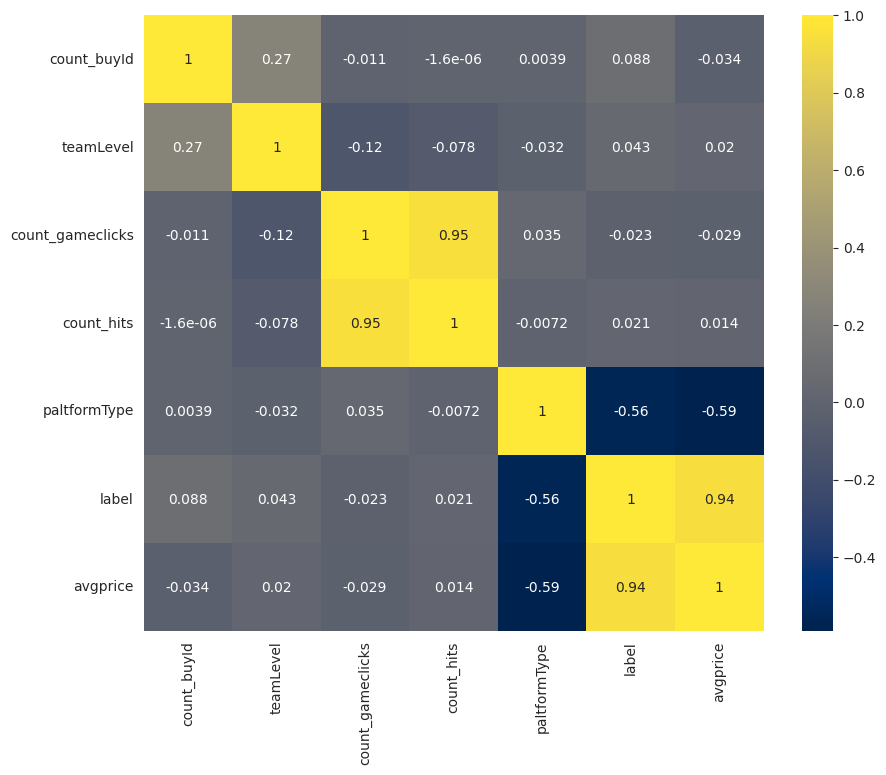

<Figure size 640x480 with 0 Axes>

In [ ]:
# Correlation analysis 
import seaborn as sns


# Calculate the correlation matrix
correlation_matrix = p_df.corr()

# Create a correlation plot using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="cividis")
plt.show()
plt.savefig("correlation_plot.png")

In [ ]:
#consolidate all of the predictor columns into a single column
# Create an assembler object
import pyspark.ml.feature
import pyspark.ml.classification 
import pyspark.ml.evaluation
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier

assembler = VectorAssembler(inputCols=[
    'teamLevel',
    'count_gameclicks', 
    'count_hits', 'count_buyId', 'paltformType' 
], outputCol='features')

df_assembled = assembler.transform(new_df)
train, test = df_assembled.randomSplit([0.7, 0.3], seed = 2029)
randomforest = RandomForestClassifier()

rand_model = randomforest.fit(train)
predictions_lr = rand_model.transform(test)


evaluator = MulticlassClassificationEvaluator()


rf_accuracy = evaluator.evaluate(predictions_lr) 
print("Test accuracy for Randmo Forest = " + str(rf_accuracy))

Test accuracy for Randmo Forest = 0.7545146708544336


In [ ]:
dt = DecisionTreeClassifier()

dt_model = dt.fit(train)
predictions_dt = dt_model.transform(test)
predictions_dt.show(5, True)

+-----------+---------+----------------+----------+------------+-----+--------+--------------------+-----------------+--------------------+----------+
|count_buyId|teamLevel|count_gameclicks|count_hits|paltformType|label|avgprice|            features|    rawPrediction|         probability|prediction|
+-----------+---------+----------------+----------+------------+-----+--------+--------------------+-----------------+--------------------+----------+
|          1|        1|              32|         3|           0|    2|      20|[1.0,32.0,3.0,1.0...|   [5.0,9.0,22.0]|[0.13888888888888...|       2.0|
|          1|        1|              36|         2|           0|    2|      20|[1.0,36.0,2.0,1.0...|   [5.0,9.0,22.0]|[0.13888888888888...|       2.0|
|          1|        1|              39|         0|           1|    0|       1|[1.0,39.0,0.0,1.0...|[502.0,32.0,30.0]|[0.89007092198581...|       0.0|
|          1|        1|              39|         4|           1|    0|       3|[1.0,39.0,4.0,1

In [ ]:
dt_accuracy = evaluator.evaluate(predictions_dt) 
print("Test accuracy for Decision Tree = " + str(dt_accuracy))

Test accuracy for Decision Tree = 0.737496574304352


In [ ]:
game_adClicks.createOrReplaceTempView("ads")

In [ ]:
## This is formatted as code
clust_df = spark.sql(
    """
    with buy_agg as (
      select userId, SUM(price) as total_price
      from BuyClicks
      group by userId
    ),

     ads_click as (
        select userId, COUNT(*) as total_adsClick
        from ads
        group by userId
      ),
    user_age as (
          select userId, (2023 - EXTRACT(year FROM dob)) as age 
          from users
      )

      select b.userId, b.total_price, a.total_adsClick, u.age
      from buy_agg b
      join ads_click a
      on b.userId = a.userId
      join user_age u
      on b.userId = u.userId

    """
)

In [ ]:
clust_df.show()

+------+-----------+--------------+---+
|userId|total_price|total_adsClick|age|
+------+-----------+--------------+---+
|  1645|       16.0|            41| 32|
|   471|      202.0|            51| 41|
|  2142|       22.0|            46| 27|
|  2122|        8.0|            17| 65|
|   243|       14.0|            56| 26|
|  1721|        8.0|            26| 74|
|  1522|       20.0|            39| 59|
|  2387|       45.0|            16| 49|
|  1270|       80.0|            44| 68|
|  1143|       43.0|            41| 42|
|  1303|        5.0|             3| 52|
|  2259|        3.0|            23| 29|
|   808|       47.0|            25| 58|
|  2025|       30.0|             6| 33|
|    65|       27.0|            38| 27|
|   970|      112.0|            49| 66|
|  1157|       13.0|            36| 49|
|   799|        6.0|            19| 49|
|  2035|       40.0|             5| 32|
|  1016|       10.0|            52| 41|
+------+-----------+--------------+---+
only showing top 20 rows



In [ ]:
clust_df = clust_df.select(['total_price','age', 'total_adsClick'])

In [ ]:
clust_df.show()

+-----------+---+--------------+
|total_price|age|total_adsClick|
+-----------+---+--------------+
|       16.0| 32|            41|
|      202.0| 41|            51|
|       22.0| 27|            46|
|        8.0| 65|            17|
|       14.0| 26|            56|
|        8.0| 74|            26|
|       20.0| 59|            39|
|       45.0| 49|            16|
|       80.0| 68|            44|
|       43.0| 42|            41|
|        5.0| 52|             3|
|        3.0| 29|            23|
|       47.0| 58|            25|
|       30.0| 33|             6|
|       27.0| 27|            38|
|      112.0| 66|            49|
|       13.0| 49|            36|
|        6.0| 49|            19|
|       40.0| 32|             5|
|       10.0| 41|            52|
+-----------+---+--------------+
only showing top 20 rows



In [ ]:
from numpy import array
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [ ]:
assembler = VectorAssembler(inputCols=[
    'total_price','total_adsClick','age'
], outputCol='features')

df_assembled = assembler.transform(clust_df)

In [ ]:

# Apply k-means with different value of k

from pyspark.mllib.linalg import DenseVector
from math import sqrt


def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

    
def algo():
  wsseList = []
  for k in range(2, 10):
    k_means = KMeans(featuresCol='features', k=k)
    model = k_means.fit(df_assembled)
    predictions = model.transform(df_assembled)
    featuresAndPrediction = predictions.select("features", "prediction")
    W = computeCost(featuresAndPrediction, model)
    # evaluator = ClusteringEvaluator()
    # silhouette_score[k] = evaluator.evaluate(predictions)
    #silhouette_scores.append(silhouette_score)
    wsseList.append(W)
  return wsseList

wsse = algo()
# Plot the cost function
# fig, ax = plt.subplots(1, 1, figsize =(16, 8))

# ax.plot(silhouette_score.keys(), silhouette_score.values())
# ax.set_xlabel('k')
# ax.set_ylabel('silhouette_score')

<Axes: xlabel='k'>

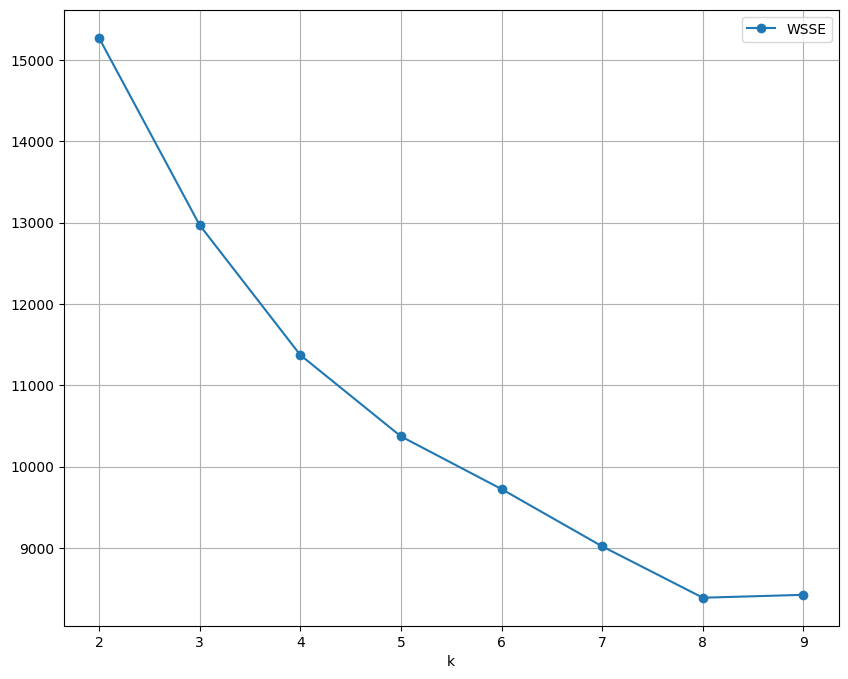

In [ ]:
wsseDF = pd.DataFrame({'WSSE' : wsse, 'k' : range(2,10) })
wsseDF.plot(y='WSSE', x='k', figsize=(10,8), grid=True, marker='o')

In [ ]:
k_means = KMeans(featuresCol='features', k=4)
model = k_means.fit(df_assembled)

In [ ]:
centers =model.clusterCenters() 
center_l = [a.tolist() for a in centers]
center_l
centers_df = pd.DataFrame(center_l, columns=['total_price','age','total_adsClick'])
centers_df.head()

,total_price,age,total_adsClick
0,23.163842,40.677966,47.604520
1,12.916667,14.681373,43.960784
2,146.386364,41.090909,45.750000
3,69.415254,33.449153,47.025424


In [ ]:
# simple bar graph
fig = px.scatter(           # replace line with bar in line chart code 
    st_p,
    x="total_price", 
    y="strength",
    template = "plotly")

fig.update_layout(
    xaxis_title = '<b><span style="font-family: Arial, font-size: 10pt">Total Price</span></b>',
    yaxis_title = '<b><span style="font-family: Arial, font-size: 10pt">Strength</span></b>',
    xaxis = dict(           # attribures for x axis 
        showline = True,
        showgrid = True,
        linecolor = 'black',
        tickfont = dict(
            family = 'Times New Roman',
            size = 18
        )
    ),
    yaxis = dict(           # attribures for y axis 
        showline = True,
        showgrid = True,
        linecolor = 'black',
        tickfont = dict(
            family = 'Times New Roman',
            size = 18
        )
    ),
    plot_bgcolor = 'white' 
)
fig.show()
fig.write_image(f"images/{img_name}.png", scale=6, width=800, height=600)

Code for Graph Using Neo4j (Cypher Language) 

In [ ]:
CREATE CONSTRAINT ON (u:User) ASSERT u.id IS UNIQUE; 
CREATE CONSTRAINT ON (t:Team) ASSERT t.id IS UNIQUE; 
CREATE CONSTRAINT ON (c:TeamChatSession) ASSERT c.id IS UNIQUE; 
CREATE CONSTRAINT ON (i:ChatItem) ASSERT i.id IS UNIQUE; 


In [ ]:
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1l-wWSIc2GUAfiUP36a0olS0mtJhYg0LU" AS row 
MERGE (u:User {id: row.user_id})
MERGE (t:Team {id: row.team_id})
MERGE (c:TeamChatSession {id: row.assignmentId})
MERGE (u)-[:CreatesSession{timeStamp: row.date}]->(c)
MERGE (c)-[:OwnedBy{timeStamp: row.date}]->(t)


In [ ]:
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1zIfm80OGQvsksCcPqD1zBs94m9NgFGd9" AS row
MERGE (u:User {id: row.user_id}) 
MERGE (c:TeamChatSession {id: row.assignmentId}) 
MERGE (u)-[:Join{timeStamp: row.date}]->(c)


In [ ]:
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1JA3EHBabiHz_LwHmB2bS4Z2cLCemKCsb" AS row 
MERGE (u:User {id: row.user_id}) 
MERGE (c:TeamChatSession {id: row.assignmentId}) 
MERGE (u)-[:Leaves{timeStamp: row.date}]->(c)

In [ ]:
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1uOONrvPDLMkPKrq_HZwIksOmimeOCWU3" AS row 
MERGE (u:User {id: row.user_id}) 
MERGE (c:TeamChatSession {id: row.click_id}) 
MERGE (i:ChatItem {id: row.tx_id}) 
MERGE (u)-[:CreateChat{timeStamp: row.date}]->(i) 
MERGE (i)-[:PartOf{timeStamp: row.date}]->(c)


In [ ]:
#mentions dataset
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1SaRYi2XikyRDVuzgTZ-JlWVnSz2Yv3WB" AS row 
MERGE (i:ChatItem {id: row.tx_id}) 
MERGE (u:User {id: row.user_id}) 
MERGE (i)-[:Mentioned{timeStamp: row.date}]->(u)

In [ ]:
#response dataset
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1NX-VCREo62vlInWCkXr0q9_mzJHmBWzv" AS row 
MERGE (i:ChatItem {id: row.assignmentId}) 
MERGE (j:ChatItem {id: row.tx_id}) 
MERGE (i)-[:ResponseTo{timeStamp: row.date}]->(j)


In [ ]:
MATCH gh=(u:User)- [:CreateChat] - (i:ChatItem) - [:ResponseTo] -(i2:ChatItem) - [:PartOf] - (c:TeamChatSession) - [:OwnedBy] -> (t) 
RETURN gh LIMIT 200

In [ ]:
MATCH gh=()-[r:OwnedBy]->() RETURN gh LIMIT 2000

In [ ]:
match gh = (p:User) - [:Mentioned] - (a:ChatItem) - [:ResponseTo] -() return gh limit 100

In [ ]:
match gh = (p:User) - [:Join] - (q:TeamChatSession) - [:Leaves] -()
return gh limit 100